# Brandenburg

Every federal state is represented by its own input directory and is processed into a NUTS level 2 directory containing a sub-folder for each discharge location. These folder names are derived from NUTS and reflect the CAMELS id. The NUTS level 2 code for Brandenburg is `DE4`.

To pre-process the data, you need to write (at least) two functions. One should extract all metadata and condense it into a single `pandas.DataFrame`. This is used to build the folder structure and derive the ids.
The second function has to take an id, as provided by the state authorities, called `provider_id` and return a `pandas.DataFrame` with the transformed data. The dataframe needs the three columns `['date', 'q' | 'w', 'flag']`.

For easier and unified output handling, the `camelsp` package contains a context object called `Bundesland`. It takes a number of names and abbreviations to identify the correct federal state and returns an object that holds helper and save functions.

The context saves files as needed and can easily be changed to save files with different strategies, ie. fill missing data with NaN, merge data into a single file, create files for each variable or pack everything together into a netcdf.

In [1]:
import pandas as pd
import geopandas as gpd
from pandas.errors import ParserError
import os
from pprint import pprint
from tqdm import tqdm
from typing import Union, Dict, Tuple
import zipfile
from datetime import datetime as dt
from io import StringIO
import warnings
from dateparser import parse

from camelsp import Bundesland, Station

The context can also be instantiated as any regular Python class, ie. to load only the default input data path, that we will user later.

In [2]:
# the context also makes the input path available, if camelsp was install locally
BASE = Bundesland('Brandenburg').input_path
BASE

'/home/alexd/Projekte/CAMELS/Github/camelsp/input_data/BR_Brandenburg'

### Metadata reader

Define the function that extracts / reads and eventually merges all metadata for this federal state. You can develop the function here, without using the Bundesland context and then later use the context to pass extracted metadata. The Context has a function for saving *raw* metadata, that takes a `pandas.DataFrame` and needs you to identify the id column.
Here, *raw* refers to provider metadata, that has not yet been transformed into the CAMELS-de Metadata schema.

Nice, Brandenburg is quite cool. This will be hard to parse. Let's first extract the big Zip, because it's a zip of Excel, with MANY sheets. To make thing more complicated, they splitted the Excel files into two files, I guess because they got too large (haha).

In [3]:
# extract the ZIP in place
if not os.path.exists(os.path.join(BASE, 'Q.TagWerte_1.xlsx')):
    with zipfile.ZipFile(os.path.join(BASE, 'Anlage_4_W_Q-TagWerte.zip')) as z:
        for f in z.filelist:
            z.extract(f, BASE)

Extract the metadata from each sheet, for this, first read in all files and create a mapping from station ids to the sheet in the respective excel_file. 

Ah, nice, why call them by their name if you can just call them 'Zeitreihe_1', 'Zeitreihe_2' and so on?

In [4]:
q1 = pd.ExcelFile(os.path.join(BASE, 'Q.TagWerte_1.xlsx'))
q2 = pd.ExcelFile(os.path.join(BASE, 'Q.TagWerte_2.xlsx'))
w1 = pd.ExcelFile(os.path.join(BASE, 'W.TagWerte_1.xlsx'))
w2 = pd.ExcelFile(os.path.join(BASE, 'W.TagWerte_2.xlsx'))

In [5]:
name = 'Zeitreihe_1'
df = q1.parse(name, header=None, usecols=[0,1,2,3])
df.head(15)

,0,1,2,3
0,Name,"Alt Ruppin, Schleuse OP.Q.TagWerte",NaN,NaN
1,ID,165666,NaN,NaN
2,Parameter,Durchfluss,NaN,NaN
3,Einheit,m³/s,NaN,NaN
4,Anzahl Messwerte,15327,NaN,NaN
5,Messwerte von,01.11.1980 00:00:00,NaN,NaN
6,Messwerte bis,18.10.2022 00:00:00,NaN,NaN
7,NaN,NaN,NaN,NaN
8,Name vom Messort/ Messgebiet,"Alt Ruppin, Schleuse OP, 5891200",NaN,NaN
9,Pegelname,"Alt Ruppin, Schleuse OP",NaN,NaN


This will be a tough sunday.

The header is changing its size. I hope the blocks stay the same...

In [6]:
def parse_dirty_dataframe(df: pd.DataFrame, variable: str, skip_data: bool = False) -> Tuple[Dict, pd.DataFrame]:
    """
    Parse the dirty dataframe directly read from the excel sheets.

    """
    # get all empty row, as they separate the block, of course
    null_idx = df[df.isnull().all(axis=1) == True].index.to_list()

    # mark all block as None for now
    ID = None
    base = {}
    loc = {}
    co = {}
    dat = None

    # We expect three blocks here, base metadata, location metadata, coordinates and data
    for i, (lo, up) in enumerate(zip([0] + null_idx, null_idx + [len(df)])):
        # extract the block
        block = df.iloc[lo:up, :]

        # switch the block
        # data block - skipping for now
        if i == 3 and not skip_data:
            # on i==0, the ID should be filled, otherwise we have to handcraft this data
            if ID is None:
                continue
            
            # get the block
            block = block.dropna(axis=0, how='all').dropna(axis=1, how='all')

            # set the header
            block.columns = block.iloc[0, :]
            block.drop(block.index[0], axis=0, inplace=True)

            # transform the data as everything is string, of course
            dat = pd.DataFrame({
                'date': [d.date() if isinstance(d, dt) else parse(d) for d in block.iloc[:, 0].values],
                variable.lower(): block.iloc[:, 1].astype(float),
                'flag': [fl.strip().lower() == 'geprüft' for fl in block.iloc[:, 3].values]
            })
        
        # base data or Standord
        if i == 0 or i == 1:

            block = block.iloc[:, :2].dropna(axis=1, how='all').dropna(axis=0, how='all')
            block = block.set_index(0).T.to_dict(orient='records')

            if len(block) > 0:
                if i == 0:
                    if 'ID' in block[0].keys():
                        ID = str(block[0]['ID'])
                    else:
                        warnings.warn(f"Block #{i + 1}: No ID found. This will skip the data for this station.")
                    base = block[0]
                else:
                    loc = block[0]
            else:
                warnings.warn(f"Block #{i + 1}: did not yield the correct shape. Please check the file. Skipping.")
        
        # Koordinaten
        elif i == 2:

            # drop NaNs on both axis
            block = block.dropna(axis=1, how='all').dropna(axis=0, how='all')
            
            # rename the CRS header
            block.iloc[0, 0] = 'CRS'
            block.columns = block.iloc[0]
            block.drop(block.index[0], axis=0, inplace=True)
            block = block.to_dict(orient='records')

            if len(block) > 0:
                co = block[0]
            else:
                warnings.warn(f"Block #{i + 1} did not yield the correct shape. Please check the file. Skipping.")

    # now merge the metadata
    meta = {**base, **loc, **co}

    # if there was no metadata, set meta None again
    if len(meta.keys()) == 0:
        meta = None
    
    # make sure that data colum time is a Date object
    dat['date'] = pd.to_datetime(dat['date'])

    # finally return all we got as a dictionary indexed by the ID (Messstellennummer)
    return {'meta': meta, 'data': dat}


# Test the stuff
data = parse_dirty_dataframe(df, 'q', skip_data=False)

data

{'meta': {'Name': 'Alt Ruppin, Schleuse OP.Q.TagWerte',
  'ID': '165666',
  'Parameter': 'Durchfluss',
  'Einheit': 'm³/s',
  'Anzahl Messwerte': '15327',
  'Messwerte von': '01.11.1980 00:00:00',
  'Messwerte bis': '18.10.2022 00:00:00',
  'Name vom Messort/ Messgebiet': 'Alt Ruppin, Schleuse OP, 5891200',
  'Pegelname': 'Alt Ruppin, Schleuse OP',
  'Gewaesser': 'Rhin (Ruppiner Wasserstraße)',
  'Status': 'Aktuell',
  'Betreiber': 'LfU Brandenburg',
  'PNP_Höhenstatus': 'DHHN2016',
  'PNP_Höhe': '34.965',
  'Fluss_KM': '49.901',
  'FlussohMdg': '45.42',
  'Gew_Kennz': '588',
  'Meldewesen': 'täglicher Meldedienst',
  'Pegelklasse': 'Gewässerkundliches Netz (GK)',
  'Messstellennummer': '5891200',
  'CRS': 'UTM 33N',
  'Ost/RW': '354590.00',
  'Nord/HW': '5869955.00'},
 'data':             date     q   flag
 26    1980-11-01  2.20   True
 27    1980-11-02  2.20   True
 28    1980-11-03  2.20   True
 29    1980-11-04  2.20   True
 30    1980-11-05  2.20   True
 ...          ...   ...   

## Generate metadata and data in Memory

I hope all the stuff can be put into Memory at once, otherwise we have to chunk it.

In [7]:
# empty container for the data
# metadata, data, warns = [], [], []
data, warns = [], []

with warnings.catch_warnings(record=True) as wa:
    # extract from each of the four excel sheets
    for variable, xls in zip(('q', 'q', 'w', 'w'), (q1, q2, w1, w2)):
        # go for each sheet
        for sheet_name in tqdm(xls.sheet_names):
            # load the dirty sheet
            df = xls.parse(sheet_name, header=None, usecols=[0,1,2,3])

            # parse it
            station_data = parse_dirty_dataframe(df, variable)

            if station_data['meta'] is not None and station_data['data'] is not None:
                data.append(station_data)
            else:
                raise Warning("Empty data or metadata")

    # copy warnings
    warns.extend(wa)

# print(f"metadata length: {len(metadata)}    data files: {len(data)}      warnings:{len(warns)}")
print(f"number of data and metadata files: {len(data)}      warnings:{len(warns)}")

100%|██████████| 115/115 [00:38<00:00,  2.97it/s]

number of data and metadata files: 382      warnings:0


There are seperate sheets for Q and W at the same station with seperate metadata.  
As we save metadata for stations, not for Q and W data, we have to merge these metadata somehow.

In [8]:
all_stations = [station['meta']['Pegelname'] for station in data]

all_ids = [station['meta']['Messstellennummer'] for station in data]

print(f"Number of IDs: {len(set(all_ids))}\nNumber of Station Names: {len(set(all_stations))}")

Number of IDs: 233
Number of Station Names: 232


There is one more ID (Messstellennummer) than station names (Pegelname), so we have a duplicate station name with different IDs.  
I spotted the duplicate, it is Pegel "Golzow", as metadata is different, we keep both stations and use the Messstellennummer for station identification!

In [9]:
for station in data:
    if station['meta']['Pegelname'] == 'Golzow':
        print(station['meta'])

{'Name': 'Golzow.Q.TagWerte', 'ID': '277576', 'Parameter': 'Durchfluss', 'Einheit': 'm³/s', 'Anzahl Messwerte': '18596', 'Messwerte von': '01.02.1969 00:00:00', 'Messwerte bis': '31.12.2019 00:00:00', 'Name vom Messort/ Messgebiet': 'Golzow, 5873300', 'Pegelname': 'Golzow', 'Gewaesser': 'Plane', 'Status': 'Aktuell', 'Betreiber': 'LfU Brandenburg', 'PNP_Höhenstatus': 'DHHN2016', 'PNP_Höhe': '38.609', 'FlussohMdg': '19.95', 'Gew_Kennz': '586', 'Meldewesen': 'kein', 'Pegelklasse': 'Gewässerkundliches Netz (GK)', 'Messstellennummer': '5873300', 'CRS': 'UTM 33N', 'Ost/RW': '337691.00', 'Nord/HW': '5793194.00'}
{'Name': 'Golzow.Q.TagWerte', 'ID': '166908', 'Parameter': 'Durchfluss', 'Einheit': 'm³/s', 'Anzahl Messwerte': '20927', 'Messwerte von': '01.05.1964 00:00:00', 'Messwerte bis': '18.10.2022 00:00:00', 'Name vom Messort/ Messgebiet': 'Golzow, 6944100', 'Pegelname': 'Golzow', 'Gewaesser': 'Schmaler Strom', 'Status': 'Aktuell', 'Betreiber': 'LfU Brandenburg', 'W_seit': '01.05.1964', 'W_b

### merge q and w data and metadata for a station

In [10]:
# merge q and w metadata for same station
data_qw = {}

# loop over all unique station ids
for station_id in set(all_ids):
    # build dictionary with metadata and merged q and w data for this station
    data_qw[station_id] = [station for station in data if station['meta']['Messstellennummer'] == station_id]

len(data_qw)

233

Another thing: there are two stations (`'0491200'` and `'6950700'`) where locations between Q and W are slightly off (maybe rounding errors), we correct this by hand:

In [11]:
# Prenzlau station
for station in data_qw['0491200']:
    print(f"{station['meta']['Name']}: RW: {station['meta']['Ost/RW']}, HW: {station['meta']['Nord/HW']}")
    # we use the rounded values of W
    if 'Q' in station['meta']['Name']:
        station['meta']['Ost/RW'] = '423373.00'
        station['meta']['Nord/HW'] = '5907471.00'
        print(f"{station['meta']['Name']}: RW: {station['meta']['Ost/RW']}, HW: {station['meta']['Nord/HW']}")

print('')

# Schönermark station
for station in data_qw['6950700']:
    print(f"{station['meta']['Name']}: RW: {station['meta']['Ost/RW']}, HW: {station['meta']['Nord/HW']}")
    # we use the rounded values of W
    if 'Q' in station['meta']['Name']:
        station['meta']['Ost/RW'] = '434966.00'
        station['meta']['Nord/HW'] = '5884700.00'
        print(f"{station['meta']['Name']}: RW: {station['meta']['Ost/RW']}, HW: {station['meta']['Nord/HW']}")

Prenzlau, Wehr UP.Q.TagWerte: RW: 423373.12, HW: 5907470.59
Prenzlau, Wehr UP.Q.TagWerte: RW: 423373.00, HW: 5907471.00
Prenzlau, Wehr UP.W.TagWerte: RW: 423373.00, HW: 5907471.00

Schönermark.Q.TagWerte: RW: 434966.13, HW: 5884699.71
Schönermark.Q.TagWerte: RW: 434966.00, HW: 5884700.00
Schönermark.W.TagWerte: RW: 434966.00, HW: 5884700.00


In [12]:
id = '6950700'

qw_station = data_qw[id]

merged_meta_qw = {}

data_q = None
data_w = None

# get metadata and data for station
for i in range(len(qw_station)):
    # get q data and metadata for station
    if qw_station[i]['meta']['Parameter'] == 'Durchfluss' and 'q' in qw_station[i]['data'].columns:
        meta_q = qw_station[i]['meta']
        data_q = qw_station[i]['data']

        # rename flag to q_flag
        data_q.rename(columns={'flag': 'q_flag'}, inplace=True)
    # get w data and metadata for station
    elif qw_station[i]['meta']['Parameter'] == 'Wasserstand' and 'w' in qw_station[i]['data'].columns:
        meta_w = qw_station[i]['meta']
        data_w = qw_station[i]['data']
        
        # rename flag to w_flag
        data_w.rename(columns={'flag': 'w_flag'}, inplace=True)
    else:
        print('Something went wrong')

# merge data if both q and w data are available
if data_q is not None and data_w is not None:
    # merge q and w data and sort by date
    station_data_qw = pd.merge(data_q, data_w, how='outer', on='date')
    station_data_qw.sort_values(by='date', inplace=True)

    # get the keys where the values are different between the dictionaries
    different_value_keys = set()
    all_keys = set(meta_w.keys()) | set(meta_q.keys())  # Combine all keys from both dictionaries

    # get the keys that are present in one dictionary but not in the other
    keys_only_in_meta_w = set(meta_w.keys()) - set(meta_q.keys())
    keys_only_in_meta_q = set(meta_q.keys()) - set(meta_w.keys())

    for key in all_keys:
        if key in meta_w and key in meta_q and meta_w[key] != meta_q[key]:
            different_value_keys.add(key)

    updated_meta_w = {}
    updated_meta_q = {}

    # Add prefix to keys that are in meta_w and meta_q for w metadata and add keys that are only in meta_w and not in meta_q
    for key in meta_w.keys():
        if key in different_value_keys or key in keys_only_in_meta_w and not key.startswith('W_'):
            updated_meta_w[f"W_{key}"] = meta_w[key]
        elif key.startswith('W_'):
            updated_meta_w[key] = meta_w[key]
        else:
            updated_meta_w[key] = meta_w[key]

    # Add prefix to keys that are in meta_w and meta_q for q metadata and add keys that are only in meta_q and not in meta_w
    for key in meta_q.keys():
        if key in different_value_keys or key in keys_only_in_meta_q and not key.startswith('Q_'):
            updated_meta_q[f"Q_{key}"] = meta_q[key]
        elif key.startswith('Q_'):
            updated_meta_q[key] = meta_q[key]
        else:
            updated_meta_q[key] = meta_q[key]

    # combine both metadata dictionaries
    merged_meta_qw = {**updated_meta_w, **updated_meta_q}
# if only q data is available
else:
    merged_meta_qw = qw_station

merged_meta_qw

{'W_Name': 'Schönermark.W.TagWerte',
 'W_ID': '277836',
 'W_Parameter': 'Wasserstand',
 'W_Einheit': 'cm',
 'W_Anzahl Messwerte': '20072',
 'W_Messwerte von': '01.11.1965 00:00:00',
 'W_Messwerte bis': '17.10.2022 00:00:00',
 'Name vom Messort/ Messgebiet': 'Schönermark, 6950700',
 'Pegelname': 'Schönermark',
 'Gewaesser': 'Welse',
 'Status': 'Aktuell',
 'Betreiber': 'LfU Brandenburg',
 'W_seit': '01.09.1965',
 'W_bis': 'aktuell',
 'Q_seit': '01.11.1968',
 'PNP_Höhenstatus': 'DHHN92',
 'PNP_Höhe': '13.245',
 'Fluss_KM': '39.605',
 'FlussohMdg': '26.5',
 'Gew_Kennz': '69628',
 'Meldewesen': 'kein',
 'Pegelklasse': 'Gewässerkundliches Netz (GK)',
 'Messstellennummer': '6950700',
 'CRS': 'UTM 33N',
 'Ost/RW': '434966.00',
 'Nord/HW': '5884700.00',
 'Q_Name': 'Schönermark.Q.TagWerte',
 'Q_ID': '165887',
 'Q_Parameter': 'Durchfluss',
 'Q_Einheit': 'm³/s',
 'Q_Anzahl Messwerte': '17453',
 'Q_Messwerte von': '01.11.1968 00:00:00',
 'Q_Messwerte bis': '18.10.2022 00:00:00'}

### merge data and metadata for all stations

In [13]:
merged_data = []

# merge the metadata for all stations
for id, qw_station in data_qw.items():
    data_q = None
    data_w = None

    # get metadata and data for station
    for i in range(len(qw_station)):
        # get q data and metadata for station
        if qw_station[i]['meta']['Parameter'] == 'Durchfluss' and 'q' in qw_station[i]['data'].columns:
            meta_q = qw_station[i]['meta']
            data_q = qw_station[i]['data']

            # rename flag to q_flag
            data_q.rename(columns={'flag': 'q_flag'}, inplace=True)
        # get w data and metadata for station
        elif qw_station[i]['meta']['Parameter'] == 'Wasserstand' and 'w' in qw_station[i]['data'].columns:
            meta_w = qw_station[i]['meta']
            data_w = qw_station[i]['data']
            
            # rename flag to w_flag
            data_w.rename(columns={'flag': 'w_flag'}, inplace=True)
        else:
            print('Something went wrong')
    
    updated_meta_w = {}
    updated_meta_q = {}

    # merge data if both q and w data are available
    if data_q is not None and data_w is not None:
        # merge q and w data and sort by date
        station_data_qw = pd.merge(data_q, data_w, how='outer', on='date')
        station_data_qw.sort_values(by='date', inplace=True)
        # make sure that flag is boolean, type boolean preserves NaN values
        station_data_qw = station_data_qw.astype({'q_flag': 'boolean', 'w_flag': 'boolean'})

        ## metadata merging
        # Get the keys where the values are different between the dictionaries
        different_value_keys = set()
        all_keys = set(meta_w.keys()) | set(meta_q.keys())  # Combine all keys from both dictionaries

        for key in all_keys:
            if key in meta_w and key in meta_q and meta_w[key] != meta_q[key]:
                different_value_keys.add(key)

        # Add prefix to keys that are in meta_w and meta_q for w metadata
        for key in meta_w.keys():
            if key in different_value_keys:
                updated_meta_w[f"W_{key}"] = meta_w[key]
            else:
                updated_meta_w[key] = meta_w[key]

        # Add prefix to keys that are in meta_w and meta_q for q metadata
        for key in meta_q.keys():
            if key in different_value_keys:
                updated_meta_q[f"Q_{key}"] = meta_q[key]
            else:
                updated_meta_q[key] = meta_q[key]

        # combine both metadata dictionaries
        merged_meta_qw = {**updated_meta_w, **updated_meta_q}
        
        # save everything to merged_data
        merged_data.append({'meta': merged_meta_qw, 'data': station_data_qw})

    elif data_q is not None:
        # we have to update the keys of the metadata to be in line with the keys of merged q-w metadata
        update_keys = ['Anzahl Messwerte', 'Einheit', 'ID', 'Messwerte bis', 'Messwerte von', 'Name', 'Parameter']

        # add prefix to keys
        for key in meta_q.keys():
            if key in update_keys:
                updated_meta_q[f"Q_{key}"] = meta_q[key]
            else:
                updated_meta_q[key] = meta_q[key]

        merged_data.append({'meta': updated_meta_q, 'data': data_q})
        
    elif data_w is not None:
        # we have to update the keys of the metadata to be in line with the keys of merged q-w metadata
        update_keys = ['Anzahl Messwerte', 'Einheit', 'ID', 'Messwerte bis', 'Messwerte von', 'Name', 'Parameter']
        # add prefix to keys
        for key in meta_w.keys():
            if key in update_keys:
                updated_meta_w[f"W_{key}"] = meta_w[key]
            else:
                updated_meta_w[key] = meta_w[key]

        merged_data.append({'meta': updated_meta_w, 'data': data_w})

merged_data

[{'meta': {'W_Name': 'Haaren.W.TagWerte',
   'W_ID': '166177',
   'W_Parameter': 'Wasserstand',
   'W_Einheit': 'cm',
   'W_Anzahl Messwerte': '7835',
   'W_Messwerte von': '01.04.2001 00:00:00',
   'W_Messwerte bis': '18.10.2022 00:00:00',
   'Name vom Messort/ Messgebiet': 'Haaren, 5930400',
   'Pegelname': 'Haaren',
   'Gewaesser': 'Karthane',
   'Status': 'Aktuell',
   'Betreiber': 'LfU Brandenburg',
   'PNP_Höhenstatus': 'DHHN2016',
   'PNP_Höhe': '27.79',
   'FlussohMdg': '25.97',
   'Gew_Kennz': '5912',
   'Pegelklasse': 'GK und KS',
   'Messstellennummer': '5930400',
   'CRS': 'UTM 33N',
   'Ost/RW': '297340.00',
   'Nord/HW': '5873210.00'},
  'data':            date     w  w_flag
  24   2001-04-01  35.0    True
  25   2001-04-02  35.0    True
  26   2001-04-03  35.0    True
  27   2001-04-04  35.0    True
  28   2001-04-05  35.0    True
  ...         ...   ...     ...
  7854 2022-10-14  36.0   False
  7855 2022-10-15  36.0   False
  7856 2022-10-16  36.0   False
  7857 2022-10

In [14]:
# check the results 
len_q = 0
len_w = 0
len_qw = 0

# count stations with q only, w only and both q and w
for station in merged_data:
    if 'W_Name' not in station['meta'].keys():
        len_q += 1
    elif 'Q_Name' not in station['meta'].keys():
        len_w += 1
    elif 'Q_Name' in station['meta'].keys() and 'W_Name' in station['meta'].keys():
        len_qw += 1
    else:
        print('unexpected')

print(f"Q only: {len_q}\nW only: {len_w}\nQ and W: {len_qw}\n\ntotal: {len_q+len_w+len_qw}\n")

Q only: 18
W only: 66
Q and W: 149

total: 233



In [15]:
# save the merged data and metadata in lists to make everything compatible to Mirkos old code
metadata = [d['meta'] for d in merged_data]
data = [d['data'] for d in merged_data]

## There is more

We have not only Anlage 4, but also Anlage 3. Check this file out:

In [16]:
# define the function 
def read_meta(base_path) -> pd.DataFrame:
    path = os.path.join(base_path, 'Anlage_3.xlsx')
    meta = pd.read_excel(path)
    return meta

# test it here
other_meta = read_meta(BASE)
pmeta = pd.DataFrame(metadata)

# merge with the other, more interesting metadata
#meta = pd.merge(pd.DataFrame(metadata), other_meta, left_on='ID', right_on='station_no', how='inner')

pmeta_names = [name.split('.')[0] for name in pmeta.Pegelname.values]

print(f"Overlapping names: {any([n in pmeta_names for n in other_meta.station_name])}")
print(f"Overlapping Messstellennummer: {any([str(i) in pmeta.Messstellennummer.values.tolist() for i in other_meta.station_no])}")

Overlapping names: True
Overlapping Messstellennummer: True


/home/alexd/miniconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [17]:
# number of unique station ids in the two datasets
print(f"Number of IDs in old (merged) metadata: {len(set([id for id in pmeta.Messstellennummer]))}")
print(f"Number of IDs in new metadata:          {len(set([id for id in other_meta.station_no]))}")

Number of IDs in old (merged) metadata: 233
Number of IDs in new metadata:          305


There are more stations in the new data, we do not have data for these stations, so we drop the metadata.

In [18]:
# join both metadata together
all_meta = pmeta.join(other_meta.set_index('station_no'), on='Messstellennummer', how='left')
all_meta

,W_Name,W_ID,W_Parameter,W_Einheit,W_Anzahl Messwerte,W_Messwerte von,W_Messwerte bis,Name vom Messort/ Messgebiet,Pegelname,Gewaesser,...,Q_Parameter,Q_Einheit,Q_Anzahl Messwerte,Q_Messwerte bis,Messwerte bis,Q_Messwerte von,Anzahl Messwerte,station_name,CATCHMENT_SIZE,BODY_RESPONSIBLE
0,Haaren.W.TagWerte,166177,Wasserstand,cm,7835,01.04.2001 00:00:00,18.10.2022 00:00:00,"Haaren, 5930400",Haaren,Karthane,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Haaren,"147,18 km²",LfU Brandenburg
1,"Rangsdorf, Wehr OP.W.TagWerte",278117,Wasserstand,cm,16726,01.11.1975 00:00:00,25.09.2022 00:00:00,"Rangsdorf, Wehr OP, 5856600","Rangsdorf, Wehr OP",Rangsdorfer See,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Rangsdorf, Wehr OP","55,46 km²",LfU Brandenburg
2,Wolfshagen.W.TagWerte,165788,Wasserstand,cm,16422,NaN,17.10.2022 00:00:00,"Wolfshagen, 5935201",Wolfshagen,Stepenitz,...,Durchfluss,m³/s,16424,19.10.2022 00:00:00,NaN,NaN,NaN,Wolfshagen,"570,46 km²",LfU Brandenburg
3,Lindena 2.W.TagWerte,300762,Wasserstand,cm,7727,01.11.2000 00:00:00,NaN,"Lindena 2, 5547401",Lindena 2,Schacke/Mühlenfließ,...,Durchfluss,m³/s,17224,NaN,05.06.2022 00:00:00,01.11.1973 00:00:00,NaN,Lindena 2,"75,19 km²",LfU Brandenburg
4,Ragow 2.W.TagWerte,277726,Wasserstand,cm,13471,01.11.1984 00:00:00,NaN,"Ragow 2, 5841801",Ragow 2,Wudritz/Ottergraben,...,Durchfluss,m³/s,21521,NaN,17.10.2022 00:00:00,01.11.1960 00:00:00,NaN,Ragow 2,"128,09 km²",LfU Brandenburg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,Guben-Sprucke.W.TagWerte,300793,Wasserstand,cm,9168,01.11.1996 00:00:00,17.10.2022 00:00:00,"Guben-Sprucke, 6670300",Guben-Sprucke,Schwarzes Fließ/Bärenklauer Wa,...,Durchfluss,m³/s,7765,18.10.2022 00:00:00,NaN,01.11.1999 00:00:00,NaN,Guben-Sprucke,"129,54 km²",LfU Brandenburg
229,Groß Linde.W.TagWerte,165964,Wasserstand,cm,8880,06.11.1997 00:00:00,18.10.2022 00:00:00,"Groß Linde, 5935206",Groß Linde,Schlatbach,...,Durchfluss,m³/s,8389,19.10.2022 00:00:00,NaN,01.11.1999 00:00:00,NaN,Groß Linde,"58,95 km²",LfU Brandenburg
230,Ketzin.W.TagWerte,166926,Wasserstand,cm,32085,01.01.1935 00:00:00,NaN,"Ketzin, 5804300",Ketzin,UHW (Havel),...,Durchfluss,m³/s,31697,NaN,18.10.2022 00:00:00,01.01.1936 00:00:00,NaN,NaN,NaN,NaN
231,Prierow 2.W.TagWerte,254672,Wasserstand,cm,13865,01.11.1984 00:00:00,17.10.2022 00:00:00,"Prierow 2, 5862201",Prierow 2,Dahme,...,Durchfluss,m³/s,22267,18.10.2022 00:00:00,NaN,01.11.1960 00:00:00,NaN,Prierow 2,"298,84 km²",LfU Brandenburg


In [19]:
# the id column will be Messstellennummer
id_column = 'Messstellennummer'

Check that we have an ID everywhere

In [20]:
print(f"All stations have an id: {all(['Messstellennummer' in m for m in metadata])}")
print(f"Any duplicated IDs:      {pd.DataFrame(metadata).Messstellennummer.duplicated().any()}")

All stations have an id: True
Any duplicated IDs:      False


### Finally run

Save the stuff using the context

In [21]:
with Bundesland('Brandenburg') as bl:
    # save the metadata
    bl.save_raw_metadata(all_meta, id_column, overwrite=True)

    # for reference, call the nuts-mapping as table
    nuts_map = bl.nuts_table
    print(nuts_map.head())
    
    # go for each of the files
    for station_meta, station_data in tqdm(zip(metadata, data), total=len(metadata)):
        # get the provider id
        provider_id = station_meta[id_column]
        
        # save
        bl.save_timeseries(station_data, provider_id)

    # check if there were warnings
    if len(warns) > 0:
        log_path = bl.save_warnings(warns)
        print(f"There were warnings during the processing. The log can be found at: {log_path}")


    nuts_id provider_id                              path
0  DE410000     5930400  ./DE4/DE410000/DE410000_data.csv
1  DE410010     5856600  ./DE4/DE410010/DE410010_data.csv
2  DE410020     5935201  ./DE4/DE410020/DE410020_data.csv
3  DE410030     5547401  ./DE4/DE410030/DE410030_data.csv
4  DE410040     5841801  ./DE4/DE410040/DE410040_data.csv


100%|██████████| 233/233 [00:05<00:00, 42.90it/s]


## Add EZG from provider to all Stations where available

In [3]:
gdf_ezg = gpd.read_file(os.path.join(BASE, '../Shapes/Brandenburg_Shapes/ezg25/ezg25_20211105/ezg25.shp'))

# save errors
errors = []

# for id in gdf_meta['PEGELID'].values:
#     # init station via PKZ, ignore warnings as we use provider_id instead of camels_id
#     try:
#         with warnings.catch_warnings():
#             warnings.simplefilter('ignore')
#             s = Station(id)
#     except ValueError as e:
#         errors.append(e)
#         continue

#     # get catchment geometry for id
#     catchment = gdf_meta[gdf_meta['PEGELID'] == id].iloc[[0]]

#     # save catchment geometry
#     s.save_catchment_geometry(catchment, datasource='federal_agency')

# # print results and number of errors
# if len(errors) > 0:
#     print("Errors:")
#     for e in errors:
#         print(e)


<Axes: >

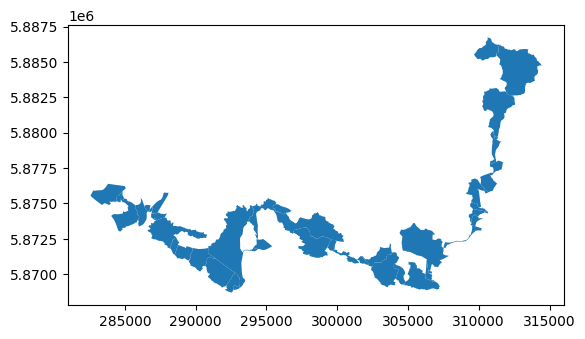

In [7]:
gdf_ezg[gdf_ezg['GEW_KENNZ'] == '5912'].plot()

In [5]:
pd.read_csv('../output_data/raw_metadata/DE4_raw_metadata.csv')

,W_Name,W_ID,W_Parameter,W_Einheit,W_Anzahl Messwerte,W_Messwerte von,W_Messwerte bis,Name vom Messort/ Messgebiet,Pegelname,Gewaesser,Status,Betreiber,PNP_Höhenstatus,PNP_Höhe,FlussohMdg,Gew_Kennz,Pegelklasse,Messstellennummer,CRS,Ost/RW,Nord/HW,W_seit,W_bis,Q_seit,Meldewesen,Messwerte von,Fluss_KM,Q_Name,Q_ID,Q_Parameter,Q_Einheit,Q_Anzahl Messwerte,Q_Messwerte bis,Messwerte bis,Q_Messwerte von,Anzahl Messwerte,station_name,CATCHMENT_SIZE,BODY_RESPONSIBLE
0,Haaren.W.TagWerte,166177.0,Wasserstand,cm,7835.0,01.04.2001 00:00:00,18.10.2022 00:00:00,"Haaren, 5930400",Haaren,Karthane,Aktuell,LfU Brandenburg,DHHN2016,27.790,25.97,5912,GK und KS,5930400,UTM 33N,297340.0,5873210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Haaren,"147,18 km²",LfU Brandenburg
1,"Rangsdorf, Wehr OP.W.TagWerte",278117.0,Wasserstand,cm,16726.0,01.11.1975 00:00:00,25.09.2022 00:00:00,"Rangsdorf, Wehr OP, 5856600","Rangsdorf, Wehr OP",Rangsdorfer See,Aktuell,LfU Brandenburg,DHHN2016,35.458,11.80,-,Gewässerkundliches Netz (GK),5856600,UTM 33N,391670.0,5792860.0,01.06.1975,aktuell,-,kein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Rangsdorf, Wehr OP","55,46 km²",LfU Brandenburg
2,Wolfshagen.W.TagWerte,165788.0,Wasserstand,cm,16422.0,NaN,17.10.2022 00:00:00,"Wolfshagen, 5935201",Wolfshagen,Stepenitz,Aktuell,LfU Brandenburg,DHHN2016,36.269,35.86,5914,Gewässerkundliches Netz (GK),5935201,UTM 33N,299785.0,5893111.0,NaN,NaN,NaN,NaN,01.11.1977 00:00:00,49.245,Wolfshagen.Q.TagWerte,165789.0,Durchfluss,m³/s,16424.0,19.10.2022 00:00:00,NaN,NaN,NaN,Wolfshagen,"570,46 km²",LfU Brandenburg
3,Lindena 2.W.TagWerte,300762.0,Wasserstand,cm,7727.0,01.11.2000 00:00:00,NaN,"Lindena 2, 5547401",Lindena 2,Schacke/Mühlenfließ,Aktuell,LfU Brandenburg,DHHN2016,90.256,1.30,53866,Gewässerkundliches Netz (GK),5547401,UTM 33N,399450.0,5717214.0,NaN,NaN,NaN,kein,NaN,NaN,Lindena 2.Q.TagWerte,277633.0,Durchfluss,m³/s,17224.0,NaN,05.06.2022 00:00:00,01.11.1973 00:00:00,NaN,Lindena 2,"75,19 km²",LfU Brandenburg
4,Ragow 2.W.TagWerte,277726.0,Wasserstand,cm,13471.0,01.11.1984 00:00:00,NaN,"Ragow 2, 5841801",Ragow 2,Wudritz/Ottergraben,Aktuell,LfU Brandenburg,DHHN2016,49.643,3.80,-,Gewässerkundliches Netz (GK),5841801,UTM 33N,424088.0,5749386.0,01.11.1984,aktuell,01.11.1984,kein,NaN,NaN,Ragow 2.Q.TagWerte,277717.0,Durchfluss,m³/s,21521.0,NaN,17.10.2022 00:00:00,01.11.1960 00:00:00,NaN,Ragow 2,"128,09 km²",LfU Brandenburg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,Guben-Sprucke.W.TagWerte,300793.0,Wasserstand,cm,9168.0,01.11.1996 00:00:00,17.10.2022 00:00:00,"Guben-Sprucke, 6670300",Guben-Sprucke,Schwarzes Fließ/Bärenklauer Wa,Aktuell,LfU Brandenburg,DHHN2016,43.835,3.47,-,Gewässerkundliches Netz (GK),6670300,UTM 33N,478937.0,5755691.0,-,-,-,kein,NaN,NaN,Guben-Sprucke.Q.TagWerte,165661.0,Durchfluss,m³/s,7765.0,18.10.2022 00:00:00,NaN,01.11.1999 00:00:00,NaN,Guben-Sprucke,"129,54 km²",LfU Brandenburg
229,Groß Linde.W.TagWerte,165964.0,Wasserstand,cm,8880.0,06.11.1997 00:00:00,18.10.2022 00:00:00,"Groß Linde, 5935206",Groß Linde,Schlatbach,Aktuell,LfU Brandenburg,DHHN2016,32.263,0.80,59146,Gewässerkundliches Netz (GK),5935206,UTM 33N,292558.0,5889624.0,NaN,NaN,NaN,täglicher Meldedienst,NaN,18.781,Groß Linde.Q.TagWerte,165963.0,Durchfluss,m³/s,8389.0,19.10.2022 00:00:00,NaN,01.11.1999 00:00:00,NaN,Groß Linde,"58,95 km²",LfU Brandenburg
230,Ketzin.W.TagWerte,166926.0,Wasserstand,cm,32085.0,01.01.1935 00:00:00,NaN,"Ketzin, 5804300",Ketzin,UHW (Havel),Aktuell,WSA Spree-Havel,DHHN92,28.388,132.35,58,Gewässerkundliches Netz (GK),5804300,UTM 33N,354399.0,5814712.0,NaN,NaN,NaN,NaN,NaN,34.050,Ketzin.Q.TagWerte,166491.0,Durchfluss,m³/s,31697.0,NaN,18.10.2022 00:00:00,01.01.1936 00:00:00,NaN,NaN,NaN,NaN
231,Prierow 2.W.TagWerte,254672.0,Wasserstand,cm,13865.0,01.11.1984 00:00:00,17.10.2022 00:00:00,"Prierow 2, 5862201",Prierow 2,Dahme,Aktuell,LfU Brandenburg,DHHN2016,53.